In [2]:
import os
import matplotlib.pyplot as plt
import scipy.misc
import sklearn.feature_extraction
import numpy as np
import scipy.ndimage
from skimage import measure, io
from skimage import transform
import train_r 
import skimage
import json
import datetime
import pickle


save_results = r'C:\Users\buggyr\Mosaic_Experiments\models'
load_training = r'C:\Users\buggyr\Mosaic_Experiments\data\processed\Training Images 3\Training_Patches32'

trainmospatches=np.load(os.path.join(load_training,'input_img_mos_patch.npy'))
trainpatches=np.load(os.path.join(load_training,'input_img_patch.npy'))

trainmospatches = (trainmospatches/255)*2 - 1
trainpatches = (trainpatches/255)*2 - 1


# vdir=r'C:\Users\buggyr\Mosaic_Experiments\data\processed\Validation Images1'
# validmospatches=np.load(os.path.join(vdir,'input_img_mos_patch.npy'))
# validpatches=np.load(os.path.join(vdir,'input_img_patch.npy'))

# valdata=(validmospatches,validpatches)

Using TensorFlow backend.


In [3]:
import keras
from keras.models import Sequential
from keras.layers import Conv2D, Activation, UpSampling2D,Reshape
from keras.optimizers import Adadelta, Nadam, RMSprop
from keras.models import load_model

In [4]:
f1 = 64
f2 = 32
f3 = 32
ff = 3
k1 = (9,9)
k2 = (1,1)
k3 = (5,5)

model = Sequential()

model.add(Conv2D(f1,k1, padding = 'same', input_shape=(None, None ,4), activation = 'relu'))

model.add(UpSampling2D(size=(2,2)))

model.add(Conv2D(f2,k2, padding = 'same', activation='relu'))

model.add(Conv2D(f3,k3, padding = 'same',activation = 'relu'))

model.add(Conv2D(ff,k3, padding = 'same',activation = 'tanh'))


#model.add(Reshape((64,64,3)))
modsum = model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, None, None, 64)    20800     
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, None, None, 64)    0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, None, None, 32)    2080      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, None, None, 32)    25632     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, None, None, 3)     2403      
Total params: 50,915
Trainable params: 50,915
Non-trainable params: 0
_________________________________________________________________


In [25]:
now=datetime.datetime.now()
save_file=os.path.join(save_results,now.strftime("%Y-%m-%d %H-%M"))
os.mkdir(save_file)
save_pred = os.path.join(save_file,'Epoch_Predictions')
os.mkdir(save_pred)

with open(os.path.join(save_file,'Model_Summary.txt'),'w') as fh:
    # Pass the file handle in as a lambda function to make it callable
    model.summary(print_fn=lambda x: fh.write(x + '\n'))
    
#rmsprop = RMSprop(lr=0.0005, rho=0.9, epsilon=1e-08, decay=0.0)
optimizer_func = Nadam(lr=0.00002, beta_1=0.9, beta_2=0.999, epsilon=1e-08, schedule_decay=0.004)
loss_func='mse'

early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=2)
tbCallBack = keras.callbacks.TensorBoard(log_dir=os.path.join(save_file,'TNSR_BRD'), histogram_freq=0, write_graph=True, write_images=True)
csv_logger = keras.callbacks.CSVLogger(os.path.join(save_file,'training.log'), separator=',', append=False)
epoch_predict = train_r.Save_predictions(save_pred)


model.compile(optimizer=optimizer_func,loss=loss_func)

In [26]:
history = model.fit(trainmospatches, trainpatches,validation_split=0.2, batch_size=32, 
                    epochs=50,verbose=1,callbacks=[tbCallBack,csv_logger,epoch_predict])
print(history.history)

model.save(os.path.join(save_file,'DeMos_mod.h5'))

Train on 64139 samples, validate on 16035 samples
Epoch 1/50
64096/64139 [============================>.] - ETA: 0s - loss: 0.0026- ETA: 0s - l

C:\ProgramData\Anaconda3\lib\site-packages\skimage\util\dtype.py:122: UserWarning: Possible precision loss when converting from float32 to uint8
  .format(dtypeobj_in, dtypeobj_out))


64139/64139 [==============================] - 69s - loss: 0.0026 - val_loss: 0.0027
Epoch 2/50
64139/64139 [==============================] - 69s - loss: 0.0022 - val_loss: 0.0024
Epoch 3/50
64139/64139 [==============================] - 69s - loss: 0.0020 - val_loss: 0.0022
Epoch 4/50
64139/64139 [==============================] - 69s - loss: 0.0018 - val_loss: 0.0019
Epoch 5/50
64139/64139 [==============================] - 69s - loss: 0.0016 - val_loss: 0.0018
Epoch 6/50
64139/64139 [==============================] - 70s - loss: 0.0015 - val_loss: 0.0016
Epoch 7/50
64139/64139 [==============================] - 69s - loss: 0.0014 - val_loss: 0.0015
Epoch 8/50
64139/64139 [==============================] - 69s - loss: 0.0013 - val_loss: 0.0014
Epoch 9/50
64139/64139 [==============================] - 69s - loss: 0.0012 - val_loss: 0.0014
Epoch 10/50
64139/64139 [==============================] - 69s - loss: 0.0011 - val_loss: 0.0013
Epoch 11/50
64139/64139 [=========================

In [ ]:
# cdir=r'C:\Train Images 2\Test Patches'
# testmospatches=np.load(os.path.join(cdir,'input_img_mos_patch.npy'))
# testpatches=np.load(os.path.join(cdir,'input_img_patch.npy'))

# print(model.evaluate(testpatches,testmospatches, verbose=1,sample_weight=None))

# print(testpatches[10].shape)
# ts1=testpatches.astype(np.uint8)
# g=ts1[10][:,:,1]
# b=ts1[10][:,:,2]
# r=ts1[10][:,:,3]

# h=np.stack((r,g,b),2)
# print(h.shape)

# plt.imshow(h)
# plt.show()
# pred_image = model.predict(np.array([testpatches[10]]), batch_size=1)[0]
# print(np.shape(np.array([testpatches[10]])))
# print(np.shape(pred_image))
# plt.imshow(pred_image.astype(np.uint8))
# plt.show()
# plt.imshow(testmospatches[10])
# plt.show()

# mse = model.evaluate(testpatches[10:11],testmospatches[10:11],batch_size=1)
# print(mse)

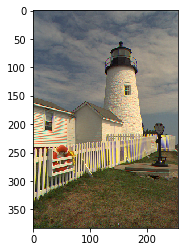

(766, 510, 3)


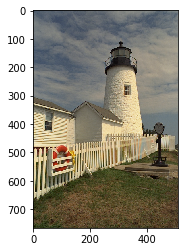

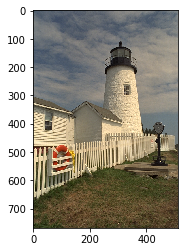

C:\ProgramData\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\ProgramData\Anaconda3\lib\site-packages\skimage\util\dtype.py:122: UserWarning: Possible precision loss when converting from float32 to uint8
  .format(dtypeobj_in, dtypeobj_out))


Mosaiced and Interpolated PSNR: 25.2504015472
Predicted PSNR: 33.6058807598
Predicted SSIM: 0.975419386306


In [34]:
i6=np.load(r'C:\Users\buggyr\Mosaic_Experiments\data\processed\Kodak_test\mos_npy\kodim19.npy')
g=i6[:,:,0]
b=i6[:,:,1]
r=i6[:,:,3]
i62=np.stack((r,g,b),2)
i62=i62.astype(np.float32)
plt.imshow(i62)
plt.show()
pred1 = model.predict(np.array([i6]), batch_size=1)[0]
print(pred1.shape)
i7 = abs(pred1)
plt.imshow(i7)
plt.show()

i8=np.load(r'C:\Users\buggyr\Mosaic_Experiments\data\processed\Kodak_test\img_npy\kodim19.npy')
plt.imshow(i8)
plt.show()

i62=(transform.rescale(i62,(2,2))).astype(np.float32) 

slh=os.path.join(save_file,'lighthouse_images')
os.mkdir(slh)

skimage.io.imsave(os.path.join(slh,'input mosaiced.png'),i62)
skimage.io.imsave(os.path.join(slh,'predicted.png'),i7)
skimage.io.imsave(os.path.join(slh,'original.png'),i8)

psnr_mos = measure.compare_psnr(i62,i8)
print('Mosaiced and Interpolated PSNR: '+str(psnr_mos))

psnr_pred = measure.compare_psnr(i7,i8)
print('Predicted PSNR: '+str(psnr_pred))

ssim= measure.compare_ssim(i7,i8,multichannel=True)
print('Predicted SSIM: '+str(ssim))



In [28]:
pred_imgs = (model.predict(np.load(r'C:\Users\buggyr\Mosaic_Experiments\data\processed\McM_test\mos_npy\sv.npy'), batch_size=1)).astype(np.uint8)
orig_imgs = (np.load(r'C:\Users\buggyr\Mosaic_Experiments\data\processed\McM_test\img_npy\sv.npy')).astype(np.uint8)
psnr=0
smpls=orig_imgs.shape[0]
for i in range(0,smpls):
    psnr = psnr + measure.compare_psnr(pred_imgs[i,:,:,:],orig_imgs[i,:,:,:])
    ssim= ssim + measure.compare_ssim(pred_imgs[i,:,:,:],orig_imgs[i,:,:,:],multichannel=True)
    
psnr_McM_avg = psnr/smpls
ssim_McM_avg = ssim/smpls    
print('McM PSNR Average: '+str(psnr/smpls))
print('McM SSIM Average: '+str(ssim_McM_avg))


ValueError: Input images must have the same dimensions.

In [29]:
import pickle
k_orig = r'C:\Users\buggyr\Mosaic_Experiments\data\processed\Kodak_test\img_lst'
k_mos = r'C:\Users\buggyr\Mosaic_Experiments\data\processed\Kodak_test\mos_lst'

with open(k_orig, "rb") as fp1:   # Unpickling
    k_or_imgs = pickle.load(fp1)
    
with open(k_mos, "rb") as fp2:   # Unpickling
    k_mos_imgs = pickle.load(fp2)

psnr = 0
ssim = 0
smpls=len(k_mos_imgs)
for i in range(0,smpls):
    pred_imgs = (model.predict(np.array([k_mos_imgs[i]]),batch_size=1)).astype(np.uint8)
    orig_imgs = (k_or_imgs[i]).astype(np.uint8) 
    psnr = psnr + measure.compare_psnr(pred_imgs[0,:,:,:],orig_imgs)
    ssim= ssim + measure.compare_ssim(pred_imgs[0,:,:,:],orig_imgs,multichannel=True)
psnr_K_avg = psnr/smpls
ssim_K_avg = ssim/smpls
print('Kodak PSNR Average: '+str(psnr_K_avg))
print('Kodak SSIM Average: '+str(ssim_K_avg))

ValueError: Input images must have the same dimensions.

In [ ]:
data = {}
data['Results'] = {
    'McM PSNR':str(psnr_McM_avg),
    'McM SSIM':str(ssim_McM_avg),
    'Kodak PSNR':str(psnr_K_avg),
    'Kodak SSIM':str(ssim_K_avg),
}
data['Parameters'] = {
    'Loss Function': loss_func,
    'Optimizer':str(type(optimizer_func))
}
data['Training Set'] = {
    'Training Path': load_training,
}

with open(os.path.join(save_file,'results.txt'), 'w') as outfile:  
    json.dump(data, outfile,indent=0)

In [24]:
import importlib
importlib.reload(train_r)

<module 'train_r' from 'C:\\Users\\buggyr\\Mosaic_Experiments\\src\\train_r.py'>